In [168]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import gym
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [169]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions,epsilon):
        super(DQN, self).__init__()
        self.nA = n_actions
        self.epsilon = epsilon
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
    def action(self,state):        
        A = np.ones(self.nA, dtype=float) * (self.epsilon/self.nA)
        temp = self.forward(state)
        best_action = temp.max(1)[1].data[0].item()
        A[best_action] += 1.0 - self.epsilon
        return A


In [170]:
class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)


    def store(self, state,action,GValue):
        state = state
        GValue = GValue
        action = action
        self.memory.append([state,action,GValue])

        
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        state,action, GValue= zip(* batch)
        return np.concatenate(state, 0),action, GValue

    def __len__(self):
        return len(self.memory)


In [171]:
def train(b_net,pi_net,buffer,optimizer,batch_size,count,soft_update):
    if len(buffer) < batch_size:
        return
    state,action, GValue = buffer.sample(batch_size)
    state = torch.tensor(state, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    GValue = torch.tensor(GValue, dtype=torch.float32, device=device)
    
    q_values = b_net.forward(state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    loss = (GValue - q_value).pow(2)
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if count % soft_update_freq == 0:
        pi_net.load_state_dict(b_net.state_dict())

In [172]:
def chooseSigma():
     return np.random.uniform(0, 1)

In [173]:
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Complete


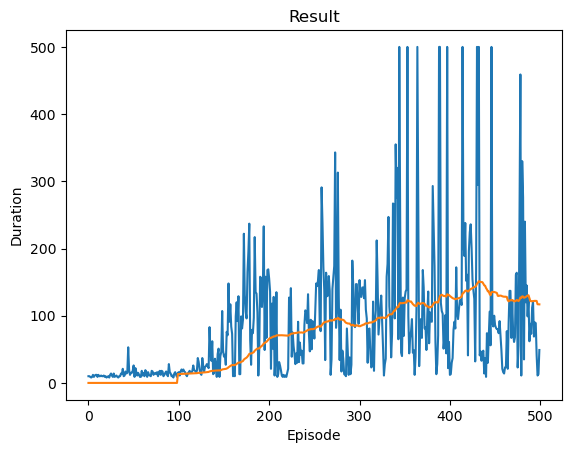

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [174]:
gamma = 0.99
learning_rate = 1e-3
batch_size = 100
soft_update = 50
capacity = 10000
exploration = 25

episode = 600
n_step = 3
render = False
count = 0

buffer = replay_buffer(1000)

env = gym.make('CartPole-v1')
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
actions = list(range(0,env.action_space.n))

b_epsilon = 0.3
pi_epsilon = 0.1
b_net = DQN(observation_dim,action_dim,b_epsilon).to(device)
pi_net = DQN(observation_dim,action_dim,pi_epsilon).to(device)
b_net.load_state_dict(pi_net.state_dict())

optimizer = torch.optim.Adam(b_net.parameters(), lr=learning_rate)
for i in range(episode):
    
    T = np.inf
    t = 0
    tau = 0
    stored_actions = {}
    stored_states = {}
    stored_rewards = {}
    stored_bProb = {}
    stored_sigma={}
    stored_G = {}
    stored_done = {}
    
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    b_prob = b_net.action(state)
    pi_prob = pi_net.action(state)
    action = np.random.choice(actions,p=b_prob)
    b_actionProb = b_prob[action]

    stored_actions[0] = action
    stored_states[0] = state
    stored_bProb[0] = b_actionProb
    while True:
    
        count = count + 1
        
        if t < T:
            state, reward, done, info = env.step(action)
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            stored_states[t+1] = state
            stored_rewards[t+1] = reward
            stored_done[t+1] = done
            if done:
                
                T = t + 1
                episode_durations.append(T)
                plot_durations()
                
            else:
                b_prob = b_net.action(state)

                
                action = np.random.choice(actions,p=b_prob)
                b_actionProb = b_prob[action]
                sigma = chooseSigma()
                
                stored_actions[t+1] = action
                stored_sigma[t+1] = sigma
                stored_bProb[t+1] = b_actionProb
                
        tau = t - n_step + 1
        if tau >= 0:
            
            if t + 1 < T:
                state_t1 = stored_states[t+1]
                action_t1 = stored_actions[t+1]
                q_t1 = pi_net.forward(state_t1).detach().squeeze(0)
                G = q_t1[action_t1]

            for k in range(min(t+1, T), tau, -1):
               
                if k == T:
                    G = stored_rewards[T]
                else:
                    s_k = stored_states[k]
                    a_k = stored_actions[k]
                    r_k = stored_rewards[k]
                    bProb_k = stored_bProb[k]
                    sigma = stored_sigma[k]
                    
                    pi_prob = pi_net.action(s_k)
                    action = np.random.choice(actions,p=pi_prob)
                    piProb_k = pi_prob[action]
                    pho_k = piProb_k / bProb_k
                    q_k = pi_net.forward(s_k).detach().squeeze(0)
                    
                    VBar = np.sum([(pi_prob[a]) * q_k[a] for a in range(action_dim)])
                    G = r_k + gamma * ((sigma * pho_k) + ((1-sigma) * pi_prob[a_k])) * (G - q_k[a_k])+ gamma * VBar
            
            stored_G[tau] = G
            buffer.store(stored_states[tau],stored_actions[tau],stored_G[tau])
        
        if i > exploration:
            train(b_net,pi_net,buffer,optimizer,batch_size,count,soft_update )
        if tau == (T-1):
            
            break
        else:
            t = t + 1

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()